In [8]:
import librosa
from IPython.display import Audio
import matplotlib.pyplot as plt
import torchaudio
import torch
from torch import nn
from torchsummary import summary

In [2]:
hop_length = 512
SAMPLE_RATE = 44100
# Create mel spectogram function
mel = torchaudio.transforms.MelSpectrogram(
    sample_rate=SAMPLE_RATE,
    n_fft=1024,
    hop_length=hop_length,
    n_mels=64
)
# Transform multiple channels to one through taking the mean
def _mix_down_if_necessary(signal):
    if signal.shape[0] > 1:
        signal = torch.mean(signal, dim=0, keepdim=True)
    return signal
# Classify audio sample
def classify_audio(audio):
    fall_spec = _mix_down_if_necessary(signal=audio)
    fall_spec = mel(fall_spec)
    fall_spec = fall_spec[None,:]
    pred = None
    with torch.no_grad():
        pred = cnn(fall_spec)
    return torch.max(pred, 1)
# Plot audio
def plot_audio(audio, sr):
    mixed = _mix_down_if_necessary(audio)
    waveform = mixed.numpy()
    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sr
    fig, axs = plt.subplots(1, 2)
    axs[0].plot(time_axis, waveform[0], linewidth=1)
    axs[0].grid(True)
    axs[0].set_title("Waveform")
    axs[1].set_title("Spectrogram (db)")
    axs[1].set_ylabel("freq_bin")
    axs[1].set_xlabel("frame")
    im = axs[1].imshow(librosa.power_to_db(mel(mixed)[0]), origin="lower", aspect="auto",cmap='magma')
    fig.colorbar(im, ax=axs[1])
    fig.set_size_inches(20, 5)
    plt.show(block=False)

# Audio data samples
Collected audio data has been categorised up into ambient and fall samples. Here is an ambient file.

In [5]:
ambient, sr = torchaudio.load('ambient noise/ambient_111_0.wav')
Audio(data=ambient, rate=sr)

The waveform and mel spectogram are shown below

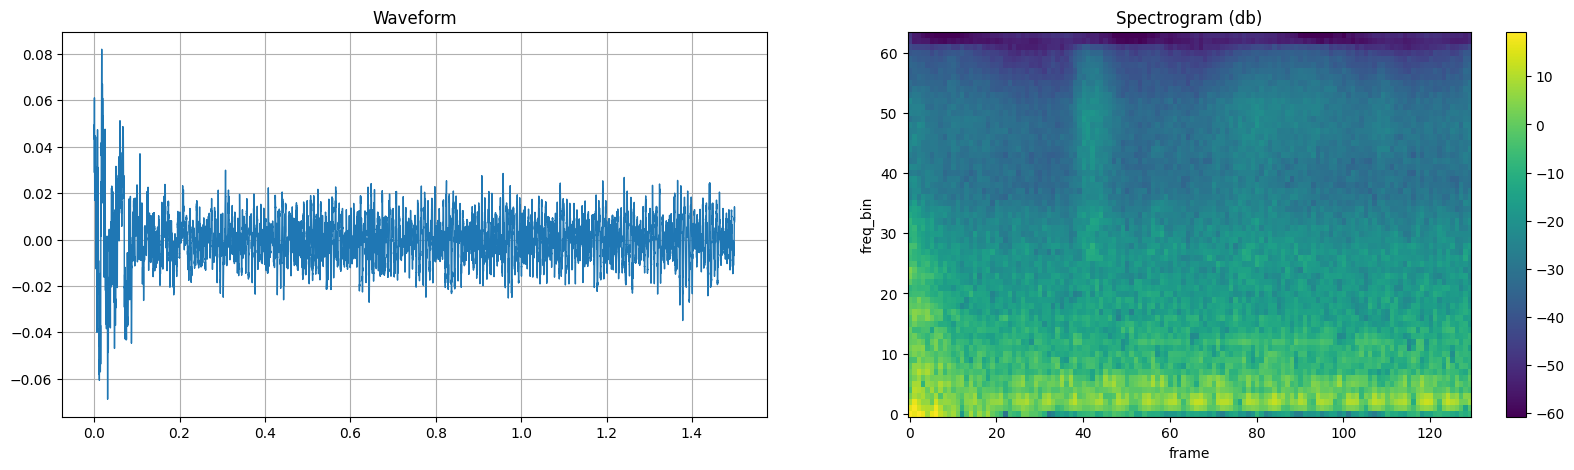

In [6]:
plot_audio(ambient, sr)

In [16]:
pambient, asr = torchaudio.load('percussive_audio/ambient noise/ambient_111_0.wav')
Audio(data=pambient, rate=asr)

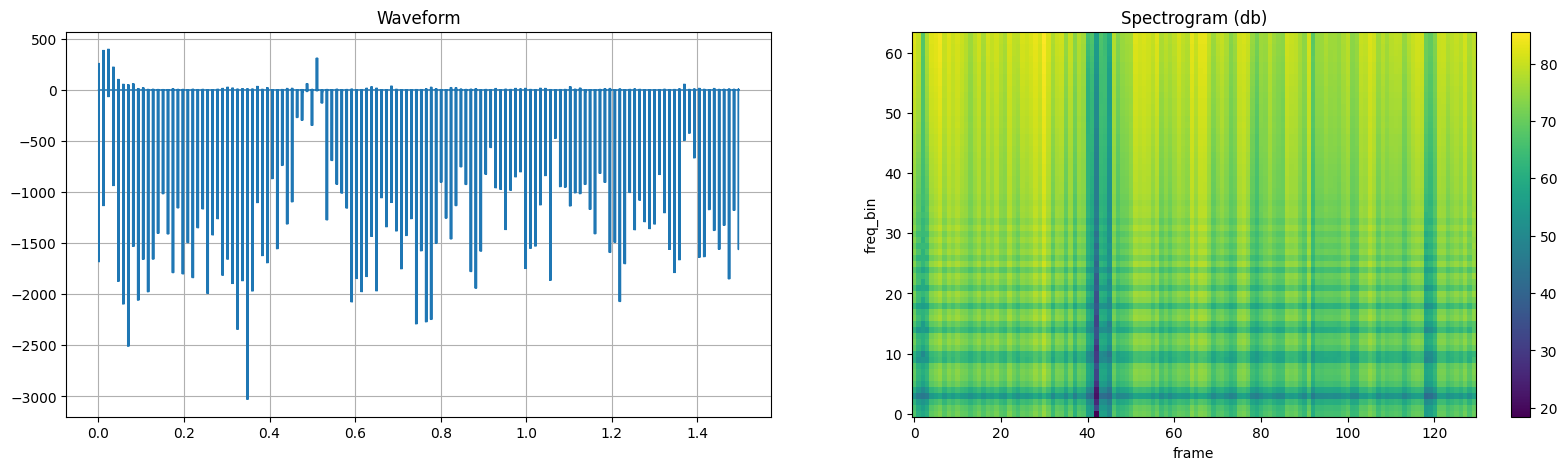

In [17]:
plot_audio(pambient, sr)

We now follow the same process for a fall clip

In [ ]:
fall, fsr = torchaudio.load('random_falls/random-fall_2_1.wav')
Audio(data=fall, rate=fsr)

In [ ]:
plot_audio(fall, fsr)

In [ ]:
pfall, fsr = torchaudio.load('percussive_audio/random_falls/random-fall_2_1.wav')
Audio(data=pfall, rate=fsr)

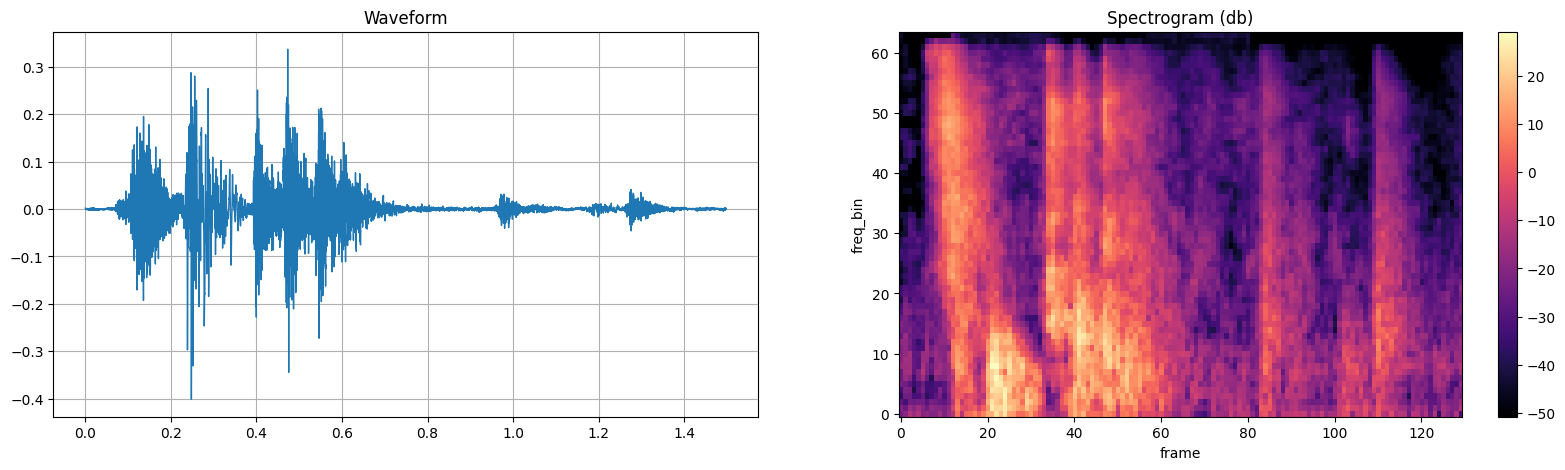

In [42]:
plot_audio(pfall, fsr)

# Classification of previous audio samples
We used the percussive audio samples for training so for more accurate results we use them to classify fall vs non fall sounds.
When we classify the sounds, we get an index that we must map to the correct labels.

In [43]:
map = ["No fall", "Fall"]

In [44]:
map[classify_audio(pambient).indices[0]]

'No fall'

In [45]:
map[classify_audio(pfall).indices[0]]

'Fall'

When a fall occurs, we want to be able to notify an emergency contact, we can do so through sending them a text.

In [46]:
from twilio.rest import Client
import os
from dotenv import load_dotenv
load_dotenv()

account_sid = os.environ["TWILACC"]
auth_token = os.environ["TWILAUTH"]
client = Client(account_sid, auth_token)

message = client.messages.create(
                              messaging_service_sid='MG574bc93dd1ae401764a064ccd00a762a',
                              body='Fall has occurred',
                              to='+15875906624'
                          )

print(message.sid)

SM2c08d128cc0c729124339b2aa7de5878


# Appendix:

### Helper functions

### Convolutional Neural Network
Below is the structure of the convolutional neural network used for our model

In [ ]:
class BCNNNetwork(nn.Module):

    def __init__(self):
        super().__init__()
        # 4 conv blocks / flatten / linear / softmax
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=16,
                kernel_size=3,
                stride=1,
                padding=2
            ),
            nn.BatchNorm2d(
                num_features = 16,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=16,
                out_channels=32,
                kernel_size=3,
                stride=1,
                padding=2
            ),
            nn.BatchNorm2d(
                num_features = 32,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(
                in_channels=32,
                out_channels=64,
                kernel_size=3,
                stride=1,
                padding=2
            ),
            nn.BatchNorm2d(
                num_features = 64,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(

            nn.Conv2d(
                in_channels=64,
                out_channels=128,
                kernel_size=3,
                stride=1,
                padding=2
            ),
            nn.BatchNorm2d(
                num_features = 128,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(3200*2, 2)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, input_data):
        x = self.conv1(input_data)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.flatten(x)
        logits = self.linear(x)
        predictions = self.softmax(logits)
        return predictions

device = torch.device("cpu")
# cnn = CNNNetwork()
cnn = torch.load('best-model-bn.pth',map_location=device)
cnn.eval()